In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importação dos Dados

In [ ]:
filmes = pd.read_csv("/content/drive/Shareddrives/Trabalho/Infraestrutura em Nuvem para Projetos com Ciência dos Dados/movies.csv")
filmes.columns = ["filmeId", "titulo", "generos"]
filmes = filmes.set_index("filmeId")
filmes.head()

,titulo,generos
filmeId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [ ]:
notas = pd.read_csv("/content/drive/Shareddrives/Trabalho/Infraestrutura em Nuvem para Projetos com Ciência dos Dados/ratings.csv")
notas.columns = ["usuarioId", "filmeId", "nota", "momento"]
notas.drop(['momento'], axis=1, inplace = True)
notas.head()

,usuarioId,filmeId,nota
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


#Pré Processamento

## Inclusão da nota média dos filmes

In [ ]:
notas_medias = notas.groupby("filmeId").mean()["nota"]
filmes["nota_media"] = notas_medias
filmes.sort_values(["nota_media"], ascending=(False)).head()
filmes.head()

,titulo,generos,nota_media
filmeId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930
2,Jumanji (1995),Adventure|Children|Fantasy,3.431818
3,Grumpier Old Men (1995),Comedy|Romance,3.259615
4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143
5,Father of the Bride Part II (1995),Comedy,3.071429


In [ ]:
df = pd.merge(notas,filmes,on='filmeId')
df.head()

,usuarioId,filmeId,nota,titulo,generos,nota_media
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093


In [ ]:
df = df.drop(columns=['usuarioId', 'nota','titulo'])
df = df.drop_duplicates()
df = df.reset_index()
df = df.drop(columns=['index'])

## One-Hot-Encoding de Gêneros

In [ ]:
generos_list = []

for genero in df['generos']:
  generos_temp = genero.split('|')
  generos_list.extend(generos_temp)

In [ ]:
generos_set = set(generos_list)
generos_set

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [ ]:
for genero in generos_set:
  df[genero] = 0

In [ ]:
df.head(1)

,filmeId,generos,nota_media,Fantasy,Documentary,Children,Crime,Thriller,IMAX,Musical,Western,War,Adventure,Mystery,Romance,Horror,Comedy,Drama,Action,(no genres listed),Sci-Fi,Film-Noir,Animation
0,1,Adventure|Animation|Children|Comedy|Fantasy,3.92093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
for index in df.index:
  lista_genero = df.loc[index]['generos'].split('|')
  for gen in lista_genero:
    df.loc[df.index[index], gen] = 1

In [ ]:
df = df.drop(columns = ['(no genres listed)', 'generos'])

In [ ]:
df.tail(3)

,filmeId,nota_media,Fantasy,Documentary,Children,Crime,Thriller,IMAX,Musical,Western,War,Adventure,Mystery,Romance,Horror,Comedy,Drama,Action,Sci-Fi,Film-Noir,Animation
9721,160836,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
9722,163937,3.5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9723,163981,3.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Normalização dos Dados

In [ ]:
scaler = MinMaxScaler()
X = np.array(df.drop(columns=['filmeId']))
scaler.fit_transform(X)

array([[0.76020672, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.61324786, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76579521, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55555556, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Agrupamento com K-Means

## Encontrando um bom valor de K

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 665

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(655, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

In [ ]:
sil

[0.5022296660308061,
 0.5073656748548362,
 0.5080343924325014,
 0.50052449944725,
 0.49599375367498755,
 0.4948843673366416,
 0.5079008143905441,
 0.5022400531639628,
 0.5025347187576822,
 0.5054387178695414,
 0.5076469079630154]

## Treinamento do K-Means

In [ ]:
model = KMeans(n_clusters=265)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=265, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Contando os itens dentro dos clusters

In [ ]:
output = model.predict(X)
df['class'] = output

In [ ]:
# quantos clusters tem menos de 5 filmes? O ideal é nenhum.
val = pd.Series(df['class'].value_counts() < 5)
val.value_counts()

False    265
Name: class, dtype: int64

In [ ]:
df['class'].value_counts()

21     312
1      286
39     207
18     204
96     198
      ... 
133      6
235      6
170      6
167      5
250      5
Name: class, Length: 265, dtype: int64

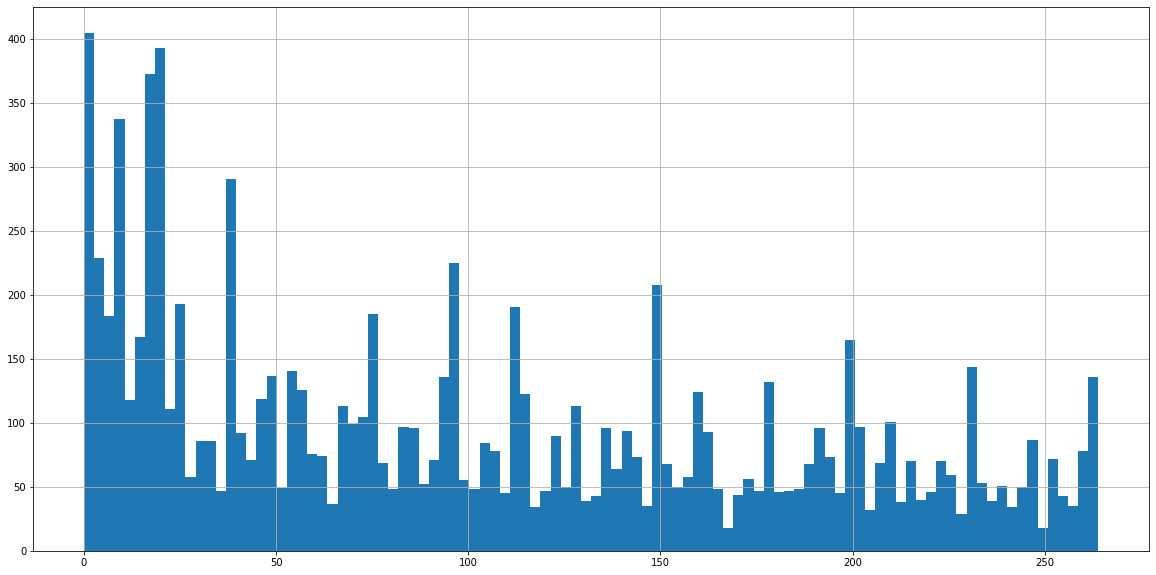

In [ ]:
df['class'].hist(bins=100, figsize=(20,10))

In [ ]:
df.shape

(9724, 22)

# Exportando os dados rotulados

In [ ]:
df.to_csv("/content/drive/Shareddrives/Trabalho/Infraestrutura em Nuvem para Projetos com Ciência dos Dados/processed_movies_2.csv", index=False)